In [1]:
# GENERATE THE RAW CSV FILE
import yfinance as yf
import os
import pandas as pd

ticker = "SPY"

def downloadStockData(ticker, start_date, end_date, interval="1d"):
    # Fetch data from Yahoo Finance
    stockData = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return stockData

def saveToCSV(stockData, ticker, file_path="raw_csvFiles/"):
    # Create the directory if it doesn't exist
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
    # File path where data will be saved
    csv_filename = os.path.join(file_path, f"{ticker}.csv")
    
    # If the file exists, read it and append only new rows
    if os.path.isfile(csv_filename):
        # Read the existing data
        existing_data = pd.read_csv(csv_filename, index_col=0, parse_dates=True)
        
        # Remove rows from stockData that already exist in the CSV (based on datetime index)
        stockData = stockData[~stockData.index.isin(existing_data.index)]
        
        if not stockData.empty:
            # Append only new data if there is any
            stockData.to_csv(csv_filename, mode='a', header=False)
            print(f"Appended {len(stockData)} new rows for {ticker} to existing CSV.")
        else:
            print(f"No new data to append for {ticker}.")
    else:
        # If file doesn't exist, write data as a new CSV file
        stockData.to_csv(csv_filename, mode='w', header=True)
        print(f"Saved {ticker} data to new CSV.")

def downloadToCSV(ticker, start_date, end_date, interval="5m"):
    try:
        stockData = downloadStockData(ticker, start_date, end_date, interval)
        saveToCSV(stockData, ticker)
    except Exception as e:
        print(f"Error downloading {ticker} data: {e}")

# Example usage
start_date = "2024-11-2"
end_date = "2024-11-30"
downloadToCSV(ticker, start_date, end_date, interval="5m")


[*********************100%***********************]  1 of 1 completed

No new data to append for SPY.


In [2]:
# DEFINE FEATURE GENERATION FUNCTIONS
import talib
import numpy as np
import pandas as pd

# Weighted Moving Average (WMA) using TA-Lib
def getWeightedMovingAverage(stockData, timeperiod):
    if stockData.empty or len(stockData) < timeperiod:
        return None
    closePrices = stockData["Close"].values
    wma = talib.WMA(closePrices, timeperiod)
    return wma

# High - Low percentage difference
def getHighLowPercentageDiff(stockData):
    if stockData.empty:
        return None
    highLowPercentageDiff = ((stockData["High"] - stockData["Low"]) / stockData["Low"] * 100).values
    return highLowPercentageDiff

# Open - Close percentage change
def getOpenClosePercentageChange(stockData):
    if stockData.empty:
        return None
    openClosePctChange = ((stockData["Close"] - stockData["Open"]) / stockData["Open"] * 100).values
    return openClosePctChange

# Day of the week as sine and cosine values
def getDayOfTheWeek(stockData):
    if stockData.empty:
        return None
    day_numbers = stockData.index.dayofweek
    sine_values = np.sin(2 * np.pi * day_numbers / 7)
    cosine_values = np.cos(2 * np.pi * day_numbers / 7)
    return sine_values.values, cosine_values.values

# Daily Volume
def getDailyVolume(stockData):
    if stockData.empty:
        return None
    return stockData["Volume"].values

# Close Price
def getClosePrice(stockData):
    if stockData.empty:
        return None
    return stockData["Close"].values

# Relative Strength Index (RSI)
def getRSI(stockData, timeperiod=14):
    if stockData.empty:
        return None
    closePrices = stockData["Close"].values
    rsi = talib.RSI(closePrices, timeperiod)
    return rsi

# Simple Moving Average (SMA)
def getSimpleMovingAverage(stockData, timeperiod=14):
    if stockData.empty:
        return None
    closePrices = stockData["Close"].values
    sma = talib.SMA(closePrices, timeperiod)
    return sma

# Balance of Power (BOP)
def getBOP(stockData):
    if stockData.empty:
        return None
    openPrices = stockData["Open"].values
    highPrices = stockData["High"].values
    lowPrices = stockData["Low"].values
    closePrices = stockData["Close"].values
    bop = talib.BOP(openPrices, highPrices, lowPrices, closePrices)
    return bop

# Exponential Moving Average (EMA)
def getEMA(stockData, timeperiod=14):
    if stockData.empty:
        return None
    closePrices = stockData["Close"].values
    ema = talib.EMA(closePrices, timeperiod)
    return ema

# Bollinger Bands (BBANDS)
def getBollingerBands(stockData, timeperiod=20, nbdevup=2, nbdevdn=2):
    if stockData.empty:
        return None
    closePrices = stockData["Close"].values
    upperband, middleband, lowerband = talib.BBANDS(closePrices, timeperiod, nbdevup, nbdevdn)
    return upperband, middleband, lowerband

In [3]:
# CREATE THE PREPARED CSV FILE
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import numpy as np

ticker = "SPY"


# task fix to work with 5m time frame
# generate label that holds the percentage change
def generate_label_based_on_percentage_change(df, threshold=5):
    # Calculate the future close price (shift the 'Close' column by 1 day)
    df["Future_Close"] = df["Close"].shift(-1)
    
    # Calculate the percentage change between future close and current close
    df["Percentage_Change"] = (df["Future_Close"] - df["Close"]) / df["Close"] * 100
    
    # Assign the percentage change as the label
    df["Label"] = df["Percentage_Change"]
    
    return df

def get_labels_v2(stock_data):
    labeled_data = generate_label_based_on_percentage_change(stock_data, 0.50)
    return labeled_data

def addFeatures(stock_data):
    bop = getBOP(stock_data)
    stock_data["BOP"] = bop

    ema = getEMA(stock_data)
    stock_data["EMA"] = ema

    rsi = getRSI(stock_data)
    stock_data["RSI"] = rsi

    upperband, middleband, lowerband = getBollingerBands(stock_data)
    stock_data["BollingerUpper"] = upperband
    stock_data["BollingerLower"] = lowerband
    stock_data["BollingerMiddle"] = middleband

    highLowPercentages = getHighLowPercentageDiff(stock_data)
    stock_data["HighLowPercentageDiff"] = highLowPercentages

    openClosePercentages = getOpenClosePercentageChange(stock_data)
    stock_data["OpenClosePercentageDiff"] = openClosePercentages

    # ALL 1S TEST
    stock_data['All_1s'] = 1

def main():
    stock_data_dataframe = pd.read_csv(f"raw_csvFiles/{ticker}.csv")
    stock_data_dataframe['Datetime'] = pd.to_datetime(stock_data_dataframe['Datetime']) 
    stock_data_dataframe.set_index('Datetime', inplace=True)
    features = stock_data_dataframe.copy()  

    addFeatures(features)
    
    features.dropna(inplace=True)

    # Generate labels for the data
    labeled_data = get_labels_v2(features)

    # Drop rows with NAN values in labeled data
    labeled_data.dropna(inplace=True)

    # Remove any extra undesired columns -- FINAL STEP 
    labeled_data.drop(["Future_Close", "Percentage_Change", "Open", "High", "Low", "Adj Close"], axis=1, inplace=True)

    print("Sample data:")
    print(labeled_data.head(10))
    print(labeled_data.shape)
    print("columns in labeled_data:", labeled_data.columns) 

    labeled_data.to_csv(f"prepared_csvFiles/{ticker}.csv")

if __name__ == "__main__":
    main()


Sample data:
                                Close   Volume       BOP         EMA  \
Datetime                                                               
2024-11-04 11:05:00-05:00  571.750000   105730  0.197398  571.641212   
2024-11-04 11:10:00-05:00  571.924988  2146228  0.381978  571.679048   
2024-11-04 11:15:00-05:00  571.479980   214618 -0.721622  571.652506   
2024-11-04 11:20:00-05:00  571.190002   214246 -0.595214  571.590839   
2024-11-04 11:25:00-05:00  571.109985   215454 -0.296875  571.526725   
2024-11-04 11:30:00-05:00  570.400024   265846 -0.855357  571.376498   
2024-11-04 11:35:00-05:00  569.859985   370834 -0.830543  571.174297   
2024-11-04 11:40:00-05:00  569.450012   627758 -0.465049  570.944392   
2024-11-04 11:45:00-05:00  568.917480   477685 -0.816578  570.674137   
2024-11-04 11:50:00-05:00  568.779907   357896 -0.382654  570.421573   

                                 RSI  BollingerUpper  BollingerLower  \
Datetime                                          

Using device: cuda
Training samples: 1352
Testing samples: 72
Number of training batches: 11
Number of testing batches: 1
Epoch 1
-------------------------------
Train Loss: 0.0227
Test Loss: 0.0221
Epoch 2
-------------------------------
Train Loss: 0.0224
Test Loss: 0.0218
Epoch 3
-------------------------------
Train Loss: 0.0224
Test Loss: 0.0215
Epoch 4
-------------------------------
Train Loss: 0.0216
Test Loss: 0.0212
Epoch 5
-------------------------------
Train Loss: 0.0218
Test Loss: 0.0210
Epoch 6
-------------------------------
Train Loss: 0.0213
Test Loss: 0.0207
Epoch 7
-------------------------------
Train Loss: 0.0209
Test Loss: 0.0205
Epoch 8
-------------------------------
Train Loss: 0.0207
Test Loss: 0.0202
Epoch 9
-------------------------------
Train Loss: 0.0204
Test Loss: 0.0200
Epoch 10
-------------------------------
Train Loss: 0.0204
Test Loss: 0.0197
Epoch 11
-------------------------------
Train Loss: 0.0198
Test Loss: 0.0195
Epoch 12
--------------------

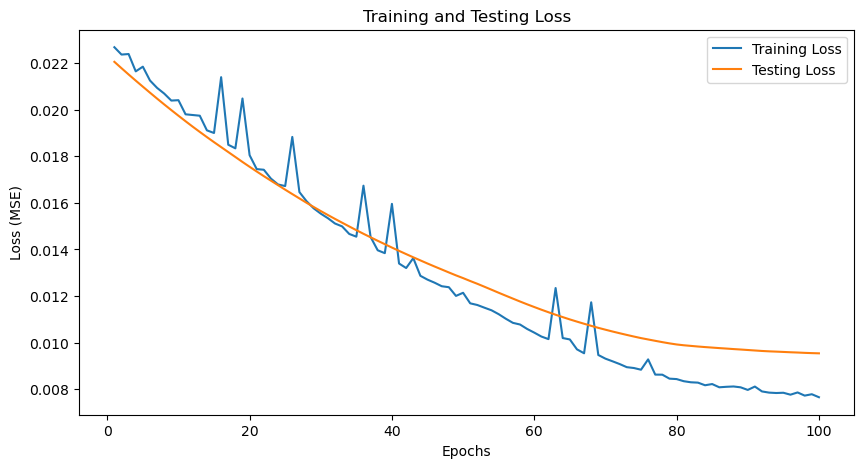

In [13]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

ticker = "SPY"

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def main():
    # Define a custom dataset class
    class CustomDataset(Dataset):
        def __init__(self, data, labels):
            self.features = data
            self.labels = labels

            # Convert to tensors
            self.features = torch.tensor(self.features, dtype=torch.float32)
            self.labels = torch.tensor(self.labels, dtype=torch.float32)

        def __len__(self):
            return len(self.features)

        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
        
    # Load data and preprocess it
    csvFile = (f"prepared_csvFiles/{ticker}.csv")
    data = pd.read_csv(csvFile)

    # choose the features and labels from the dataframe
    # features = data[["Volume", "RSI", "HighLowPercentageDiff", "OpenClosePercentageDiff", "BOP"]].to_numpy()
    features = data[["Volume"]]
    labels = data["Label"].to_numpy()

    inputFeatureLength = features.shape[1]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.05, random_state=24)

    # Normalize the features (fit on training data only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    joblib.dump(scaler, 'trainedModelConfigs/scaler.pkl')
   
    # Create Dataset objects
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Create DataLoader objects
    batch_size = 128
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    num_train_batches = len(train_dataloader)
    num_test_batches = len(test_dataloader)
    print(f"Number of training batches: {num_train_batches}")
    print(f"Number of testing batches: {num_test_batches}")
    
    class RegressionModel(nn.Module):
        def __init__(self):
            super(RegressionModel, self).__init__()
            
            # Define a smaller model with fewer parameters for regression
            self.fc1 = nn.Linear(inputFeatureLength, 25)   # Input layer (inputFeatureLength features -> 25 neurons)
            self.fc2 = nn.Linear(25, 64) 
            self.fc3 = nn.Linear(64, 64) 
            self.fc4 = nn.Linear(64, 64)  
            self.fc5 = nn.Linear(64, 16)   # Output layer (1 output for regression, predicting percentage change)
            self.fc6 = nn.Linear(16, 1)   # Output layer (1 output for regression, predicting percentage change)

            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.relu(self.fc3(x))
            x = self.relu(self.fc4(x))
            x = self.relu(self.fc5(x))
            x = self.fc6(x)  # No activation here, output is a continuous value
            return x


    model = RegressionModel().to(device)
    loss_fn = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    # Training function for regression
    def train(dataloader, model, loss_fn, optimizer):
        model.train()  # Set the model to training mode
        total_loss = 0

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Forward pass
            pred = model(X)  # Predicted values (continuous)

            # Calculate loss (Mean Squared Error for regression)
            y = y.unsqueeze(1)  # This will change y from [84] to [84, 1]
            loss = loss_fn(pred, y)  # Pred is continuous values, y is the actual percentage change
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(dataloader)  # Average MSE loss
        return avg_loss

    # Testing function for regression
    def test(dataloader, model, loss_fn):
        model.eval()  # Set the model to evaluation mode
        test_loss = 0

        with torch.no_grad():  # No need to track gradients during testing
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)

                # Forward pass
                pred = model(X)  # Predicted values (continuous)

                # Calculate loss (Mean Squared Error for regression)
                y = y.unsqueeze(1)  # This will change y from [84] to [84, 1]
                loss = loss_fn(pred, y)
                test_loss += loss.item()

        avg_loss = test_loss / len(dataloader)  # Average MSE loss
        return avg_loss

    # Lists to store the metrics for plotting
    train_losses = []  # to store training loss (MSE)
    test_losses = []   # to store testing loss (MSE)

    # Training Loop
    epochs = 100
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Train and test the model
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        test_loss = test(test_dataloader, model, loss_fn)

        # Append the values to the respective lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Print the training and test losses
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

    # Now, create a range for the epochs (1 to 500)
    epochs_range = range(1, epochs + 1)

    # Plot loss (MSE)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_losses, label="Training Loss")
    plt.plot(epochs_range, test_losses, label="Testing Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.title("Training and Testing Loss")

    # Show the plots
    plt.show()

    torch.save(model.state_dict(), 'trainedModelConfigs/model.pth')

if __name__ == "__main__":
    main()


In [15]:
# TESTING THE TRAINED MODEL
import torch
from torch import nn
import pandas as pd
import joblib

ticker = "SPY"


    
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        
        # Define a smaller model with fewer parameters for regression
        self.fc1 = nn.Linear(1, 25)   # Input layer (inputFeatureLength features -> 25 neurons)
        self.fc2 = nn.Linear(25, 64) 
        self.fc3 = nn.Linear(64, 64) 
        self.fc4 = nn.Linear(64, 64)  
        self.fc5 = nn.Linear(64, 16)   # Output layer (1 output for regression, predicting percentage change)
        self.fc6 = nn.Linear(16, 1)   # Output layer (1 output for regression, predicting percentage change)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)  # No activation here, output is a continuous value
        return x

def main():
    # Load the trained model
    model = RegressionModel()  # Input features from training
    model.load_state_dict(torch.load('trainedModelConfigs/model.pth', weights_only=True))
    model.eval()  # Set the model to evaluation mode

    # Load data and preprocess it
    csvFile = f"prepared_csvFiles/{ticker}.csv"
    data = pd.read_csv(csvFile)


    # Choose the features and labels from the dataframe
    features = data[["Volume"]]
    labels = data["Label"].to_numpy()
    features = features[:20]
    labels = labels[:20]

    # Load the scaler
    scaler = joblib.load('trainedModelConfigs/scaler.pkl')

    # Preprocess the features (standardize them)
    features = scaler.transform(features)  # Same transformation as during training
    feature_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)  # Convert labels to tensor of type float32 for regression

    # Perform a forward pass to get the predictions
    with torch.no_grad():
        predictions = model(feature_tensor)

    # Calculate Mean Squared Error (MSE)
    mse_loss = torch.nn.functional.mse_loss(predictions.squeeze(), labels_tensor)
    
    # Calculate Mean Absolute Error (MAE)
    mae_loss = torch.nn.functional.l1_loss(predictions.squeeze(), labels_tensor)
    
    # Print the results
    print(f"Predictions: {predictions.squeeze()}")
    print(f"True labels: {labels_tensor}")
    print(f"Mean Squared Error: {mse_loss.item()}")
    print(f"Mean Absolute Error: {mae_loss.item()}")

if __name__ == "__main__":
    main()


Predictions: tensor([-0.0122,  0.0091, -0.0139, -0.0139, -0.0139, -0.0147, -0.0163, -0.0195,
        -0.0180, -0.0161, -0.0188, -0.0185, -0.0162, -0.0166, -0.0144, -0.0149,
        -0.0151, -0.0136, -0.0133, -0.0129])
True labels: tensor([ 0.0306, -0.0778, -0.0507, -0.0140, -0.1243, -0.0947, -0.0719, -0.0935,
        -0.0242,  0.0123, -0.0473, -0.1075,  0.1127,  0.0422,  0.1310,  0.0729,
         0.0228, -0.0035,  0.0246,  0.0767])
Mean Squared Error: 0.00536855636164546
Mean Absolute Error: 0.06174372509121895
